In [1]:
import pandas as pd
import json
import numpy as np
from collections import OrderedDict
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from imblearn.over_sampling.random_over_sampler import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("dark")

%matplotlib inline

In [2]:
yearly_prs = []
insolvency_data = []
for line in open("../data/evolving_pagerank_large_graph_yearly_experiment.jsonline"):
    record = json.loads(line)
    yearly_prs += [dict(record["pr"])]
    insolvency_data += [{"id": record["id"], "stringId": record["stringId"], "nodeType": record["nodeType"]}]
yearly_prs_df = pd.DataFrame(yearly_prs)
insolvency_data_df = pd.DataFrame(insolvency_data)
assert yearly_prs_df.shape[0] == insolvency_data_df.shape[0]

In [3]:
yearly_prs_df = yearly_prs_df.drop([2008, 2009, 2010], axis=1)

## Preprocessing

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
WINDOW_SIZE = 4
dataset_df = pd.DataFrame()
dataset_insdata_df = pd.DataFrame()
for window in rolling_window(yearly_prs_df.columns, WINDOW_SIZE):
    features = yearly_prs_df[window[:WINDOW_SIZE - 1]]
    features.columns = np.array(
        map(lambda idx: "year_{}".format(idx), reversed(range(1, len(window[:-1]) + 1)))
    )
    
    pred = yearly_prs_df[[window[-1]]]
    pred.columns = np.array(["year_0"])
    dataset_df = dataset_df.append(pd.concat([features, pred], axis=1))
    dataset_insdata_df = dataset_insdata_df.append(insolvency_data_df)
    
assert dataset_insdata_df.shape[0] == dataset_df.shape[0]

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [7]:
X = dataset_df.drop("year_0", axis=1)
y = dataset_df[["year_0"]]

Text(0.5,1,'Histogram of raw values')

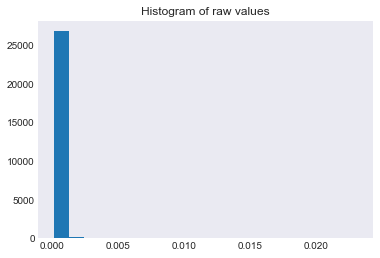

In [8]:
_ = plt.hist(y.values, 20)
plt.title("Histogram of raw values")

In [9]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

Text(0.5,1,'Histogram of values after 0-1 rescaling')

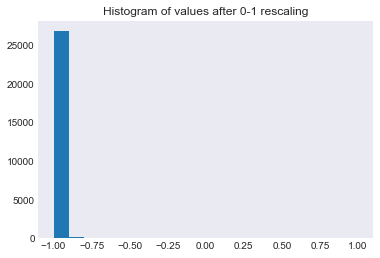

In [10]:
_ = plt.hist(y, 20)
plt.title("Histogram of values after 0-1 rescaling")

In [11]:
apply_sigmoid_func = np.vectorize(lambda x: 1 / (1 + np.exp(-4 * x)))

X = apply_sigmoid_func(X)
y = apply_sigmoid_func(y)

Text(0.5,1,'Histogram of values after applying the sigmoid function')

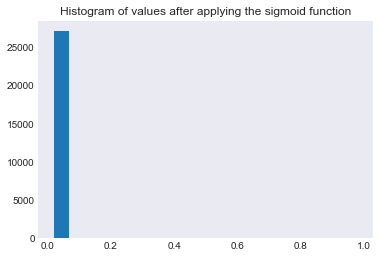

In [12]:
_ = plt.hist(y, 20)
plt.title("Histogram of values after applying the sigmoid function")

In [13]:
# y = y.ravel()
# ros = RandomOverSampler()
# y_disc = np.digitize(y, np.arange(0, 1, 0.05))

# Xy = np.column_stack((X, y))
# Xy_resampled, y_resampled = ros.fit_sample(Xy, y_disc)

# X = Xy_resampled[:,0:3]
# y = Xy_resampled[:,3:4].T[0]

# _ = plt.hist(y, 20)
# plt.title("Histogram of values after oversampling smaller classes")

## Model fitting

In [14]:
model_factory = [("simple_lr", lambda: linear_model.LinearRegression()),
                 ("mlp_single_layer_10", lambda: MLPRegressor(hidden_layer_sizes=(10,), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                 ("mlp_single_layer_20", lambda: MLPRegressor(hidden_layer_sizes=(20,), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                 ("mlp_single_layer_30", lambda: MLPRegressor(hidden_layer_sizes=(30,), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                 ("mlp_two_layer_10_10", lambda: MLPRegressor(hidden_layer_sizes=(10, 5), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                 ("mlp_two_layer_20_20", lambda: MLPRegressor(hidden_layer_sizes=(20, 10), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                 ("mlp_two_layer_30_30", lambda: MLPRegressor(hidden_layer_sizes=(30, 15), activation="logistic", alpha=0.001, early_stopping=True, max_iter=10000)),
                ]

### Basic model

In [15]:
kf = KFold(n_splits=5)
stats_dict = OrderedDict()
models_dict = OrderedDict()
for split_idx, (train, test) in enumerate(kf.split(X)):
    train_X = X[train]
    train_y = y[train]
    test_X = X[test]
    test_y = y[test]
    
    models_dict[split_idx] = {}
    print("Fitting split {}".format(split_idx))
    for name, model_builder in model_factory:
        print("\tFitting model: {}".format(name))
        stats_df = stats_dict.get(name, pd.DataFrame())
        reg = model_builder()
        reg.fit(train_X, train_y)
        pred_y = reg.predict(test_X)
        
        models_dict[split_idx][name] = reg
        stats_df = stats_df.append(pd.DataFrame(
            [{"mse": mean_squared_error(test_y, pred_y),
              "mae": mean_absolute_error(test_y, pred_y),
              "r2": r2_score(test_y, pred_y)
             }]), ignore_index=True)
        stats_dict[name] = stats_df

names, stats = zip(*stats_dict.items())
stats_df = pd.concat(stats, keys=names, axis=1)

Fitting split 0
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10


/Users/peterzvirinsky/Envs/GraphSlices/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/peterzvirinsky/Envs/GraphSlices/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 1
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 2
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 3
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 4
	Fitting model: simple_lr
	Fit

## Evaluation

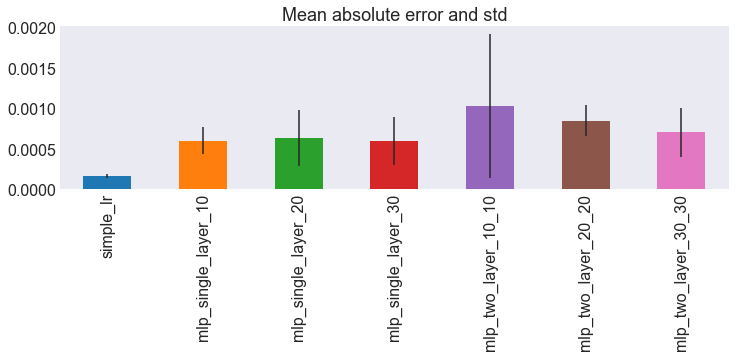

In [16]:
ax = stats_df.mean(axis=0)[:, "mae"].plot(kind="bar", yerr=stats_df.std(axis=0)[:, "mae"], figsize=(12,3), fontsize=16)
ax.set_title("Mean absolute error and std", fontsize=18);

In [17]:
stats_df.mean(axis=0).to_frame(name="mean").merge(
    stats_df.std(axis=0).to_frame("std"), left_index=True, right_index=True
)

mean       std
simple_lr           mae  0.000163  0.000024
                    mse  0.000004  0.000002
                    r2   0.993262  0.004594
mlp_single_layer_10 mae  0.000602  0.000172
                    mse  0.000048  0.000048
                    r2   0.920756  0.090236
mlp_single_layer_20 mae  0.000634  0.000344
                    mse  0.000048  0.000065
                    r2   0.917155  0.124067
mlp_single_layer_30 mae  0.000599  0.000294
                    mse  0.000066  0.000086
                    r2   0.885808  0.163956
mlp_two_layer_10_10 mae  0.001028  0.000889
                    mse  0.000173  0.000279
                    r2   0.728428  0.422658
mlp_two_layer_20_20 mae  0.000846  0.000190
                    mse  0.000063  0.000083
                    r2   0.891899  0.159041
mlp_two_layer_30_30 mae  0.000702  0.000302
                    mse  0.000053  0.000054
                    r2   0.912362  0.103823

In [18]:
test_reg = models_dict[1]["mlp_two_layer_30_30"]
SIZE = 50
X_plot = np.array([[0.016947, 0.020687],] * SIZE)
plot_dim_x = np.linspace(0., 0.2, SIZE)
X_plot = np.column_stack((X_plot, plot_dim_x))
y_plot = test_reg.predict(X_plot)

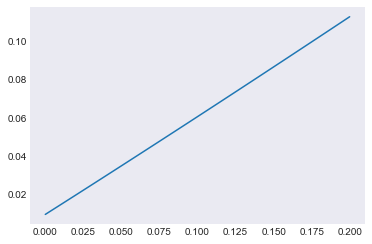

In [19]:
plt.plot(plot_dim_x, y_plot)

### Adding nodeType

In [20]:
lb = LabelBinarizer()
features_node_type = lb.fit_transform(dataset_insdata_df.nodeType)
assert features_node_type.shape[0] == X.shape[0]

X_w_node_type = np.hstack((X, features_node_type))

In [21]:
kf = KFold(n_splits=5)
stats_dict = OrderedDict()
models_dict = OrderedDict()
for split_idx, (train, test) in enumerate(kf.split(X_w_node_type)):
    train_X = X_w_node_type[train]
    train_y = y[train]
    test_X = X_w_node_type[test]
    test_y = y[test]
    
    models_dict[split_idx] = {}
    print("Fitting split {}".format(split_idx))
    for name, model_builder in model_factory:
        print("\tFitting model: {}".format(name))
        stats_df = stats_dict.get(name, pd.DataFrame())
        reg = model_builder()
        reg.fit(train_X, train_y)
        pred_y = reg.predict(test_X)
        
        models_dict[split_idx][name] = reg
        stats_df = stats_df.append(pd.DataFrame(
            [{"mse": mean_squared_error(test_y, pred_y),
              "mae": mean_absolute_error(test_y, pred_y),
              "r2": r2_score(test_y, pred_y)
             }]), ignore_index=True)
        stats_dict[name] = stats_df

names, stats = zip(*stats_dict.items())
stats_df = pd.concat(stats, keys=names, axis=1)

Fitting split 0
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 1
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 2
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 3
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fit

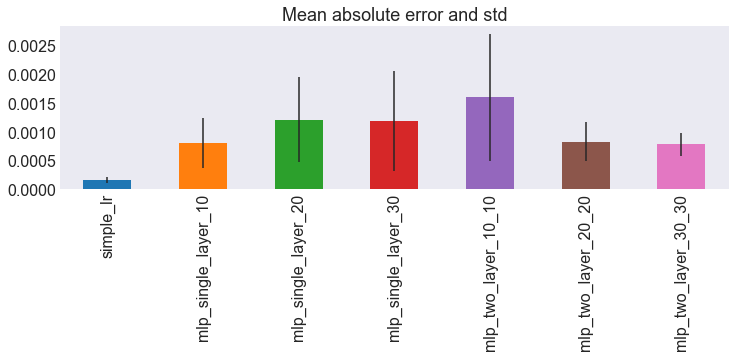

In [23]:
ax = stats_df.mean(axis=0)[:, "mae"].plot(kind="bar", yerr=stats_df.std(axis=0)[:, "mae"], figsize=(12,3), fontsize=16)
ax.set_title("Mean absolute error and std", fontsize=18);

In [24]:
stats_df.mean(axis=0).to_frame(name="mean").merge(
    stats_df.std(axis=0).to_frame("std"), left_index=True, right_index=True
)

mean       std
simple_lr           mae  0.000161  0.000049
                    mse  0.000004  0.000002
                    r2   0.993283  0.004452
mlp_single_layer_10 mae  0.000799  0.000433
                    mse  0.000127  0.000173
                    r2   0.811674  0.239794
mlp_single_layer_20 mae  0.001206  0.000735
                    mse  0.000208  0.000325
                    r2   0.709931  0.415934
mlp_single_layer_30 mae  0.001186  0.000870
                    mse  0.000186  0.000240
                    r2   0.692470  0.395085
mlp_two_layer_10_10 mae  0.001594  0.001101
                    mse  0.000348  0.000251
                    r2   0.496319  0.344020
mlp_two_layer_20_20 mae  0.000823  0.000337
                    mse  0.000060  0.000059
                    r2   0.900531  0.116703
mlp_two_layer_30_30 mae  0.000779  0.000204
                    mse  0.000060  0.000046
                    r2   0.902187  0.092261

### Clustering

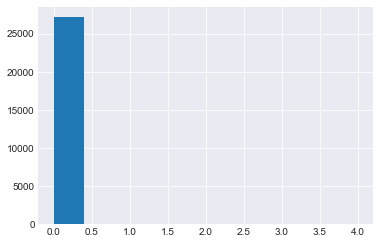

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
clusters = kmeans.fit_predict(X)
pd.Series(clusters).hist()

# Individual evaluation

In [ ]:
test_reg = models_dict[1]["mlp_single_layer_30"]

In [ ]:
def eval_node(stringId, test_reg):
    test_df = dataset_df[dataset_insdata_df["stringId"] == stringId].copy()
    test_df["year_0_pred"] = test_reg.predict(test_df.drop(["year_0"], axis=1))
    test_df["pred_err"] = (test_df["year_0_pred"] - test_df["year_0"]).abs()
    return test_df

## Creditors

In [ ]:
## GE Money Bank
eval_node("gemoneybank", test_reg)

In [ ]:
## Provident Financial
eval_node("providentfinancial", test_reg)

In [ ]:
## Cetelem
eval_node(u"cetelemčr", test_reg)

## Administrators

In [ ]:
eval_node(u"adm_5727", test_reg)

## Debtors

In [ ]:
eval_node(u"ksbrins3336/2013", test_reg)

In [ ]:
# 